<a href="https://colab.research.google.com/github/frm1789/100DaysOfPython/blob/main/Chapter3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install duckduckgo-search


In [3]:
import fastai
from fastai.vision.all import *


In [ ]:
from duckduckgo_search import DDGS
import requests
from pathlib import Path

# List of bear types
bear_types = ['black', 'grizzly', 'teddy']

# Create a directory to save images
path = Path('bear')
path.mkdir(exist_ok=True, parents=True)

# Initialize DuckDuckGo Search
with DDGS() as ddgs:
    for bear in bear_types:
        dest = path / bear  # Subdirectory for each bear type
        dest.mkdir(exist_ok=True)
        print(f"Searching images for: {bear} bear")

        # Search for images
        results = ddgs.images(f'{bear} bear', max_results=50)  # Fetch up to 50 results

        for i, result in enumerate(results):
            try:
                # Extract the image URL
                img_url = result.get('image')
                if img_url:
                    # Download the image
                    response = requests.get(img_url, stream=True)
                    response.raise_for_status()  # Raise an error for bad status codes

                    # Save the image
                    img_path = dest / f"{bear}_{i}.jpg"
                    with open(img_path, 'wb') as img_file:
                        for chunk in response.iter_content(chunk_size=8192):
                            img_file.write(chunk)

                    print(f"Downloaded: {img_path}")
                else:
                    print(f"Invalid image URL in result {i}: {result}")
            except Exception as e:
                print(f"Failed to download image {i} from {img_url}: {e}")


In [12]:
fns = get_image_files(path)
fns

(#118) [Path('bear/grizzly/grizzly_3.jpg'),Path('bear/grizzly/grizzly_17.jpg'),Path('bear/grizzly/grizzly_18.jpg'),Path('bear/grizzly/grizzly_45.jpg'),Path('bear/grizzly/grizzly_32.jpg'),Path('bear/grizzly/grizzly_20.jpg'),Path('bear/grizzly/grizzly_40.jpg'),Path('bear/grizzly/grizzly_16.jpg'),Path('bear/grizzly/grizzly_27.jpg'),Path('bear/grizzly/grizzly_21.jpg'),Path('bear/grizzly/grizzly_31.jpg'),Path('bear/grizzly/grizzly_25.jpg'),Path('bear/grizzly/grizzly_6.jpg'),Path('bear/grizzly/grizzly_48.jpg'),Path('bear/grizzly/grizzly_26.jpg'),Path('bear/grizzly/grizzly_13.jpg'),Path('bear/grizzly/grizzly_8.jpg'),Path('bear/grizzly/grizzly_14.jpg'),Path('bear/grizzly/grizzly_43.jpg'),Path('bear/grizzly/grizzly_28.jpg')...]

In [13]:
failed = verify_images(fns)
failed

(#2) [Path('bear/teddy/teddy_7.jpg'),Path('bear/teddy/teddy_6.jpg')]

In [14]:
failed.map(Path.unlink);

In [15]:
bears = DataBlock(
  blocks=(ImageBlock, CategoryBlock),
  get_items=get_image_files,
  splitter=RandomSplitter(valid_pct=0.2, seed=42),
  get_y=parent_label,
  item_tfms=Resize(128))

In [16]:
dls = bears.dataloaders(path)

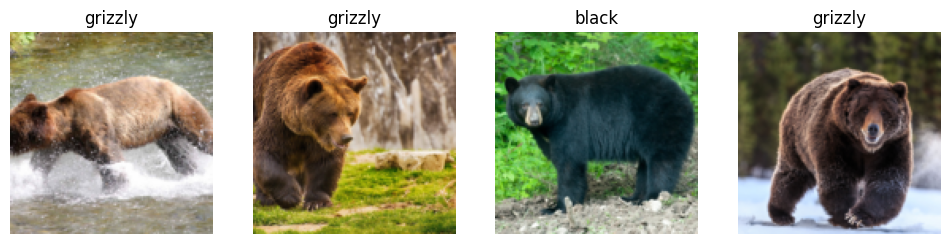

In [18]:
dls.valid.show_batch(max_n=4, nrows=1)

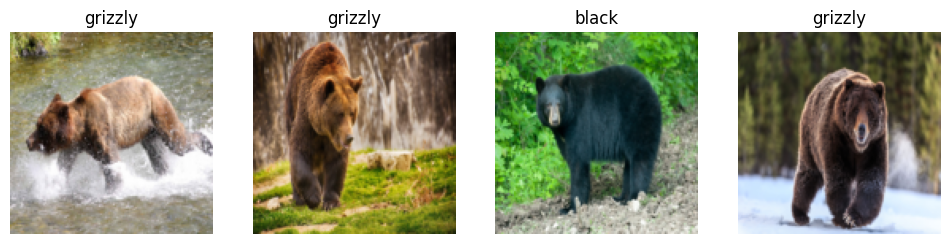

In [19]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

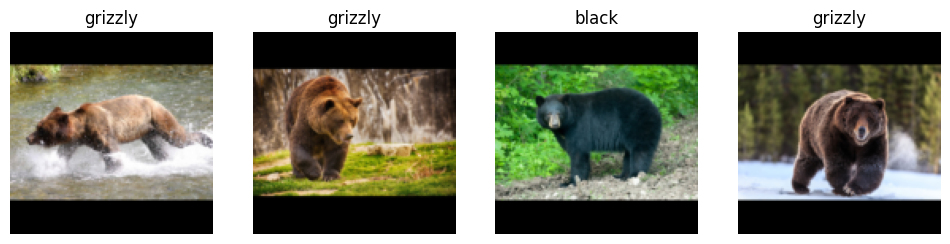

In [20]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

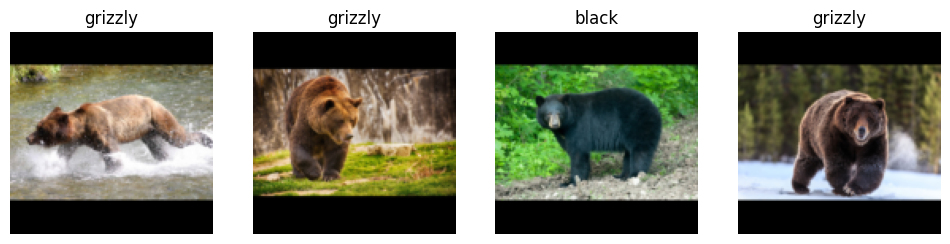

In [21]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

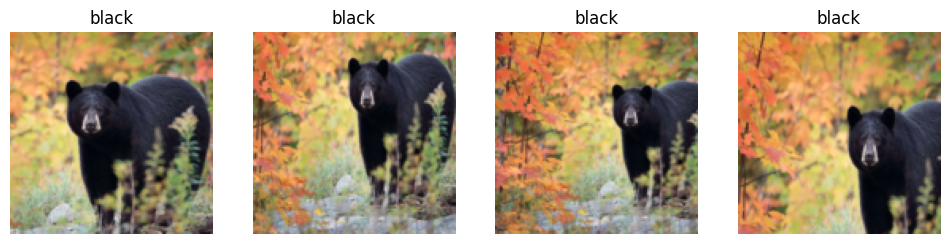

In [22]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

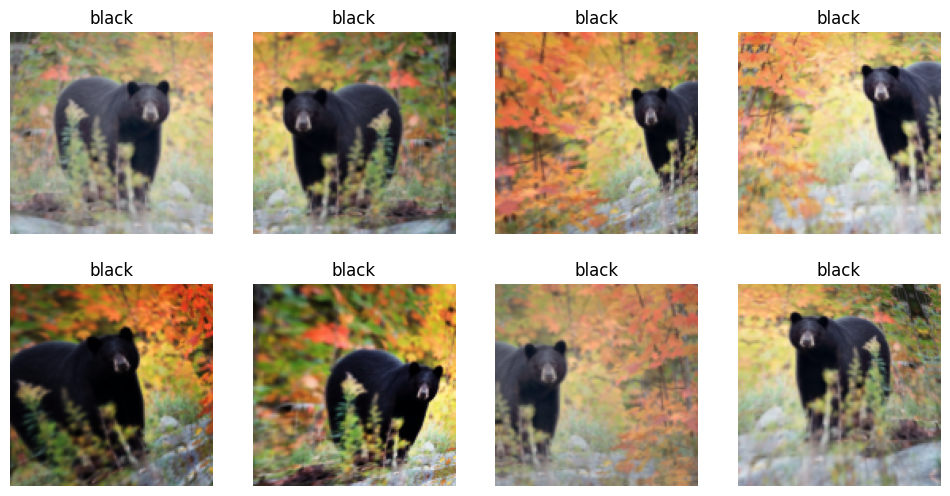

In [23]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [24]:
bears = bears.new(
item_tfms=RandomResizedCrop(224, min_scale=0.5),
batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [25]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.11/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 69.6MB/s]


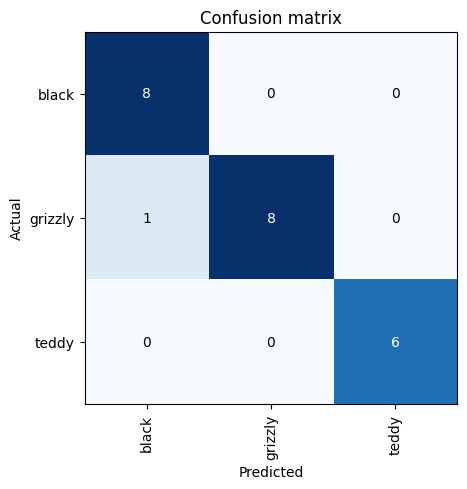

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

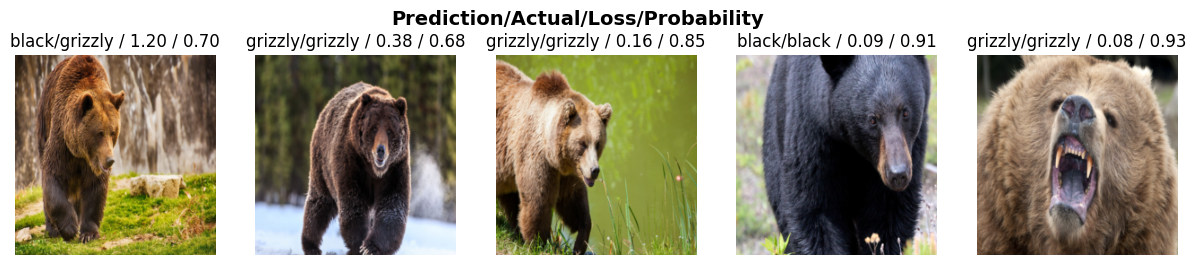

In [27]:
interp.plot_top_losses(5, nrows=1)

In [29]:
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn)
cleaner

In [34]:
import shutil
from pathlib import Path

# Ruta principal
path = Path('bear')

for idx, cat in cleaner.change():
    # Asegúrate de que la carpeta de destino existe
    dest = path / cat
    dest.mkdir(parents=True, exist_ok=True)

    # Ruta del archivo fuente
    src = Path(cleaner.fns[idx])  # Convertir a objeto Path
    filename = src.name           # Nombre del archivo
    dst = dest / filename         # Ruta destino

    # Si el archivo ya existe en la carpeta de destino
    if dst.exists():
        print(f"El archivo {dst} ya existe. Renombrando...")
        dst = dest / f"{src.stem}_copy{src.suffix}"  # Renombrar el archivo

    try:
        shutil.move(str(src), str(dst))  # Mover el archivo a la carpeta correspondiente
        print(f"Movido {src} a {dst}")
    except Exception as e:
        print(f"Error al mover el archivo {src} a {dst}: {e}")



El archivo bear/black/black_18.jpg ya existe. Renombrando...
Movido bear/black/black_18.jpg a bear/black/black_18_copy.jpg


In [35]:
learn.export()

In [36]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [37]:
learn_inf = load_learner(path/'export.pkl')

In [39]:
learn_inf.predict('bear/black/black_0.jpg')

('black', tensor(0), tensor([9.8168e-01, 1.8291e-02, 2.9010e-05]))

In [40]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']